In [ ]:
#notebook for harmonizng observations of the human data

In [1]:
#file locations
#/home/ubuntu/s3_mount/Data/HUMAN_CELLS_MS0203.h5ad
#/home/ubuntu/s3_mount/Data/human_hippo/human_hippo_sparse.h5ad
#/home/ubuntu/s3_mount/Data/tabula_sapiens

#human_cell_landscape



In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
#from scipy.optimize import curve_fit
import scvi
import pickle
from adjustText import adjust_text
import matplotlib.patches as patches
import os

Global seed set to 0


In [2]:
hdata = sc.read_h5ad('/home/ubuntu/s3_mount/Data/HUMAN_CELLS_MS0203.h5ad')

In [3]:
hdata

AnnData object with n_obs × n_vars = 920914 × 21812
    obs: 'tissue', 'cell_type', 'age', 'sex', 'donor', 'sample', 'disease', 'tech', 'study', 'ref'

# Hippo gene harmonziation

In [4]:
with open('../data/annotations/human/gencode.v28.chr_patch_hapl_scaff.annotation.gtf') as f:
    gencode = [x for x in list(f)[5:]]

In [5]:
genecode_d ={}

for entry in tqdm(gencode):
    name = entry.split('gene_name "')[1].split('"')[0]
    ensembl = entry.split('gene_id "')[1].split('"')[0].split('.')[0] #ensembl
    genecode_d[name] = ensembl
    
# {'DDX11L1': 'ENSG00000223972',
#  'WASH7P': 'ENSG00000227232',
#  'MIR6859-1': 'ENSG00000278267' ....

100%|█████████████████████████████| 2939655/2939655 [00:07<00:00, 376019.85it/s]


In [6]:
with open('../data/annotations/human/genes.gtf') as f:
    genes = [x for x in list(f)[5:]]

In [7]:
genes_d ={}

for entry in tqdm(genes):
    name = entry.split('gene_name "')[1].split('"')[0]
    ensembl = entry.split('gene_id "')[1].split('"')[0].split('.')[0] #ensembl
    genes_d[ensembl] = name
    
# {'ENSG00000223972': 'DDX11L1',
#  'ENSG00000227232': 'WASH7P',
#  'ENSG00000278267': 'MIR6859-1',
#  'ENSG00000243485': 'RP11-34P13.3',

100%|█████████████████████████████| 2765969/2765969 [00:08<00:00, 331360.35it/s]


In [8]:
hippo = sc.read_h5ad('/home/ubuntu/s3_mount/Data/human_hippo/human_hippo_sparse.h5ad')

In [9]:
hippo

AnnData object with n_obs × n_vars = 241631 × 23505
    obs: 'Age', 'Sex', 'batch', 'Disease', 'Sample'

In [10]:
len([x for x in hippo.var_names if x in hdata.var_names]) #gene overlap between the two

14910

In [11]:
len([x for x in hippo.var_names if x not in hdata.var_names]) #genes in hippo not in other

8595

In [12]:
def a_mapper(x): #takes the hippo (gencode) id and returns the 10X gtf id
    if x not in hdata.var_names:
        try:
            return genes_d[genecode_d[x]]
        except:
            return x
    else:
        return x
    
test = hippo.var_names
test = test.map(a_mapper)

In [13]:
test

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'AAAS', 'AACS',
       'AADAT', 'PRXL2C',
       ...
       'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZZEF1', 'AC118549.1',
       'bP-21201H5.1', 'CR381653.1', 'CR392039.4', 'yR211F11.2'],
      dtype='object', length=23505)

In [14]:
len([x for x in test if x not in hdata.var_names])

7621

In [15]:
hippo.var_names = hippo.var_names.map(a_mapper) #only got about 1000... but it is something

In [ ]:
#try 2

In [5]:
hippo = sc.read_h5ad('/home/ubuntu/s3_mount/Data/human_hippo/human_hippo_sparse.h5ad')

In [6]:
with open('../data/gene_lists/human_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role

markers = {k.upper(): v for k, v in markers.items()}

In [27]:
!head ../data/annotations/human/gencode.v28.metadata.HGNC

ENST00000456328.2	DDX11L1
ENST00000450305.2	DDX11L1
ENST00000488147.1	WASH7P
ENST00000619216.1	MIR6859-1
ENST00000473358.1	MIR1302-2HG
ENST00000469289.1	MIR1302-2HG
ENST00000607096.1	MIR1302-2
ENST00000417324.1	FAM138A
ENST00000461467.1	FAM138A
ENST00000606857.1	OR4G4P


In [56]:
symbol_mapper = pd.read_csv('../data/annotations/human/gencode.v28.metadata.HGNC', delimiter = '\t', header=None)

In [57]:
symbol_mapper[symbol_mapper[1] == 'CXCL8']

,0,1
42172,ENST00000307407.7,CXCL8
42173,ENST00000401931.1,CXCL8
42174,ENST00000483500.1,CXCL8


In [11]:
symbol_mapper[symbol_mapper[0].str.startswith('AC')]

,0,1


In [12]:
[x for x in hdata.var_names if x not in hippo.var_names]

['A2M-AS1',
 'A2ML1-AS1',
 'A2ML1-AS2',
 'A3GALT2',
 'A4GNT',
 'AADAC',
 'AADACL2',
 'AADACL2-AS1',
 'AADACL3',
 'AADACL4',
 'AATBC',
 'AATF',
 'ABCA9-AS1',
 'ABCB11',
 'ABCC1',
 'ABCC5-AS1',
 'ABCC6',
 'ABCF1',
 'ABHD15-AS1',
 'ABHD16A',
 'ABHD16B',
 'ABHD17C',
 'ABO',
 'ABR',
 'ABRA',
 'AC000067.1',
 'AC000124.1',
 'AC002306.1',
 'AC002386.1',
 'AC002401.1',
 'AC002480.2',
 'AC002511.2',
 'AC003009.1',
 'AC003092.1',
 'AC003092.2',
 'AC003101.1',
 'AC003956.1',
 'AC003958.2',
 'AC003985.1',
 'AC004012.1',
 'AC004063.1',
 'AC004158.1',
 'AC004490.1',
 'AC004637.1',
 'AC004869.2',
 'AC004870.3',
 'AC004988.1',
 'AC005008.2',
 'AC005009.1',
 'AC005253.2',
 'AC005256.1',
 'AC005262.2',
 'AC005304.1',
 'AC005387.2',
 'AC005394.1',
 'AC005480.1',
 'AC005498.3',
 'AC005523.2',
 'AC005616.1',
 'AC005625.1',
 'AC005703.2',
 'AC005703.3',
 'AC005863.1',
 'AC006004.1',
 'AC006007.1',
 'AC006019.3',
 'AC006041.1',
 'AC006076.1',
 'AC006150.1',
 'AC006272.1',
 'AC006296.2',
 'AC006449.2',
 'AC006

In [18]:
[x for x in hippo.var_names if x not in hdata.var_names]

['AAED1',
 'AB015752.3',
 'AB015752.4',
 'ABC11-4932300O16.1',
 'ABC12-49244600F4.3',
 'ABC14-864958H18.2',
 'ABCA11',
 'ABCA17P',
 'ABCC13',
 'ABCC6P1',
 'ABHD14A-ACY1',
 'AC000059.1',
 'AC000095.10',
 'AC000095.11',
 'AC000095.12',
 'AC000095.13',
 'AC000095.6',
 'AC000123.2',
 'AC000123.3',
 'AC000370.2',
 'AC000403.4',
 'AC002055.4',
 'AC002064.3',
 'AC002064.5',
 'AC002116.7',
 'AC002117.1',
 'AC002127.4',
 'AC002310.11',
 'AC002310.12',
 'AC002310.13',
 'AC002310.7',
 'AC002331.1',
 'AC002365.4',
 'AC002368.3',
 'AC002383.2',
 'AC002398.13',
 'AC002398.5',
 'AC002429.5',
 'AC002451.3',
 'AC002463.3',
 'AC002467.7',
 'AC002472.11',
 'AC002472.15',
 'AC002480.5',
 'AC002539.1',
 'AC002543.2',
 'AC002551.1',
 'AC002992.3',
 'AC003002.4',
 'AC003002.6',
 'AC003005.4',
 'AC003006.7',
 'AC003009.2',
 'AC003029.1',
 'AC003051.1',
 'AC003075.4',
 'AC003077.1',
 'AC003080.4',
 'AC003084.2',
 'AC003088.1',
 'AC003090.1',
 'AC003102.3',
 'AC003104.1',
 'AC003665.1',
 'AC003682.16',
 'AC0039

In [90]:
[x for x in markers if x in hippo.var_names]

['CDKN2A',
 'CDKN2B',
 'CDKN1A',
 'CDKN1B',
 'TP53',
 'RB1',
 'GLB1',
 'TFEB',
 'NFKB1',
 'CEBPB',
 'CXCR2',
 'CXCL5',
 'CXCL12',
 'CXCL13',
 'CXCL14',
 'CXCL16',
 'CCL22',
 'CCL24',
 'CCL28',
 'IL18',
 'IL7',
 'IL15',
 'MMP2',
 'MMP14',
 'MMP15',
 'MMP16',
 'MMP17',
 'MMP24',
 'MMP25',
 'TIMP1',
 'TIMP2',
 'CTSB',
 'ADAM17',
 'EPHA2',
 'TGFB1',
 'TGFB2',
 'TGFB3',
 'IGFBP2',
 'IGFBP3',
 'IGFBP4',
 'IGFBP5',
 'IGFBP7',
 'SERPINE1',
 'IRF1',
 'IRF5',
 'IFI16',
 'AREG',
 'EGF',
 'FGF2',
 'FGF7',
 'HGF',
 'VEGFA',
 'VEGFB',
 'VEGFC',
 'PIGF',
 'PLAT',
 'BCL2',
 'BCL2L1',
 'BCL2L2',
 'FOXO4']

In [68]:
symbol_mapper = pd.read_csv('../data/annotations/human/gencode.v28.metadata.HGNC', delimiter = '\t', header=None)
symbol_mapper = dict(zip(symbol_mapper[0], symbol_mapper[1]))
symbol_mapper['na'] = 'na'

In [61]:
genecode_df = []


for entry in tqdm(gencode):
    name = entry.split('gene_name "')[1].split('"')[0]
    try:
        transcript = entry.split('transcript_name "')[1].split('"')[0]#.split('.')[0] #transcript
    except:
        transcript = 'na'
    try:
        transcript_id = entry.split('transcript_id "')[1].split('"')[0]#.split('.')[0] #transcript
    except:
        transcript_id = 'na'   
        
    try:
        ensembl = entry.split('gene_id "')[1].split('"')[0]#.split('.')[0] #ensembl
    except:
        ensembl = 'na'  
    
    genecode_df.append([name, transcript, transcript_id, ensembl ])
    
    
# {'DDX11L1': 'ENSG00000223972',
#  'WASH7P': 'ENSG00000227232',
#  'MIR6859-1': 'ENSG00000278267' ....

100%|█████████████████████████████| 2939655/2939655 [00:18<00:00, 160410.43it/s]


In [69]:
genecode_df = pd.DataFrame(genecode_df, columns = ['gene', 'transcript', 'transcript_id', 'ensembl']).\
    drop_duplicates().reset_index(drop = True)

genecode_df['trans_symbol'] = genecode_df.transcript_id.map(symbol_mapper)

In [76]:
genecode_df[genecode_df.gene.isin([x for x in markers if x not in hippo.var_names])]

,gene,transcript,transcript_id,ensembl,trans_symbol
12274,NGF,na,na,ENSG00000134259.3,na
12275,NGF,RP4-662B22.1-001,ENST00000369512.2,ENSG00000134259.3,NGF
32375,IL1A,na,na,ENSG00000115008.5,na
32376,IL1A,AC112246.2-001,ENST00000263339.3,ENSG00000115008.5,IL1A
32377,IL1B,na,na,ENSG00000125538.11,na
...,...,...,...,...,...
274311,MMP11,AP000349.3-013,ENST00000628372.1,ENSG00000275365.3,MMP11
274364,MIF,na,na,ENSG00000276701.2,na
274365,MIF,AP000348.6-001,ENST00000613839.2,ENSG00000276701.2,MIF
274366,MIF,AP000348.6-002,ENST00000626906.1,ENSG00000276701.2,MIF


In [92]:
genecode_df[genecode_df.gene.isin(hippo.var_names)]

,gene,transcript,transcript_id,ensembl,trans_symbol
3,WASH7P,na,na,ENSG00000227232.5,na
4,WASH7P,RP11-34P13.2-001,ENST00000488147.1,ENSG00000227232.5,WASH7P
23,RP11-34P13.7,na,na,ENSG00000238009.6,na
24,RP11-34P13.7,RP11-34P13.7-001,ENST00000466430.5,ENSG00000238009.6,NaN
25,RP11-34P13.7,RP11-34P13.7-003,ENST00000477740.5,ENSG00000238009.6,NaN
...,...,...,...,...,...
288231,AC240274.1,AC240274.1-202,ENST00000612640.4,ENSG00000271254.6,NaN
288232,AC240274.1,AC240274.1-203,ENST00000612721.4,ENSG00000271254.6,NaN
288233,AC240274.1,AC240274.1-204,ENST00000616361.1,ENSG00000271254.6,NaN
288305,AC007325.4,na,na,ENSG00000278817.1,na


In [96]:
hippo.var_names[hippo.var_names.isin(genecode_df.transcript.values)]

Index([], dtype='object')

In [94]:
hippo.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'AAAS', 'AACS',
       'AADAT', 'AAED1',
       ...
       'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZZEF1', 'ZZZ3', 'bP-21201H5.1',
       'bP-21264C1.2', 'bP-2171C21.3', 'yR211F11.2'],
      dtype='object', length=23505)

In [83]:
hippo.var_names[hippo.var_names.str.startswith('IL1')]

Index(['IL10RA', 'IL10RB', 'IL11RA', 'IL12A', 'IL12RB1', 'IL12RB2', 'IL13RA1',
       'IL13RA2', 'IL15', 'IL15RA', 'IL16', 'IL17B', 'IL17D', 'IL17RA',
       'IL17RB', 'IL17RC', 'IL17RD', 'IL17RE', 'IL17REL', 'IL18', 'IL18BP',
       'IL18R1', 'IL18RAP', 'IL1R1', 'IL1RAP', 'IL1RAPL1', 'IL1RAPL2',
       'IL1RL1', 'IL1RL2'],
      dtype='object')

In [99]:
temp = genecode_df[(genecode_df.gene != genecode_df.trans_symbol) & (genecode_df.trans_symbol != 'na') & (~genecode_df.trans_symbol.isna())]

In [100]:
temp

,gene,transcript,transcript_id,ensembl,trans_symbol
8,RP11-34P13.3,RP11-34P13.3-001,ENST00000473358.1,ENSG00000243485.5,MIR1302-2HG
9,RP11-34P13.3,RP11-34P13.3-002,ENST00000469289.1,ENSG00000243485.5,MIR1302-2HG
32,RP11-34P13.10,RP11-34P13.10-001,ENST00000442987.3,ENSG00000233750.3,CICP27
94,RP4-669L17.6,RP4-669L17.6-001,ENST00000437905.2,ENSG00000269732.1,WBP1LP7
122,RP5-857K21.9,RP5-857K21.9-001,ENST00000416931.1,ENSG00000225972.1,MTND1P23
...,...,...,...,...,...
288199,RP13-465B17.3,RP13-465B17.3-001,ENST00000625649.1,ENSG00000280844.1,KRT18P53
288222,RP13-465B17.2,RP13-465B17.2-001,ENST00000625346.1,ENSG00000280877.1,FABP5P13
288224,RP13-465B17.3,RP13-465B17.3-001,ENST00000628961.1,ENSG00000281050.1,KRT18P53
288296,RNA5-8S4,RNA5-8S4-201,ENST00000616292.1,ENSG00000276700.1,RNA5-8SN3


In [109]:
temp = temp[temp.trans_symbol.isin(hdata.var_names[hdata.var_names.isin(temp.trans_symbol.values)])].drop_duplicates('gene')

In [111]:
mapper = dict(zip(temp.gene, temp.trans_symbol))

In [115]:
def the_mapper(x):
    try:
        return mapper[x]
    except:
        return x

In [117]:
hdata.var_names[hdata.var_names.isin(hippo.var_names)]

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'AAAS', 'AACS',
       'AADAT', 'AAGAB',
       ...
       'ZSWIM8', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A',
       'ZYG11B', 'ZZEF1'],
      dtype='object', length=14910)

In [116]:
hippo.var_names.map(the_mapper)

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'AAAS', 'AACS',
       'AADAT', 'AAED1',
       ...
       'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZZEF1', 'ZZZ3', 'bP-21201H5.1',
       'bP-21264C1.2', 'bP-2171C21.3', 'yR211F11.2'],
      dtype='object', length=23505)

In [118]:
hdata.var_names[hdata.var_names.isin(hippo.var_names.map(the_mapper))]

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A4GALT', 'AAAS', 'AACS',
       ...
       'ZSWIM8', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A',
       'ZYG11B', 'ZZEF1'],
      dtype='object', length=15836)

In [119]:
hippo.var_names_make_unique?

In [72]:
genecode_df[genecode_df.gene == 'CXCL3']

,gene,transcript,transcript_id,ensembl,trans_symbol
61827,CXCL3,na,na,ENSG00000163734.4,na
61828,CXCL3,RP11-367M19.1-001,ENST00000296026.4,ENSG00000163734.4,CXCL3
61829,CXCL3,RP11-367M19.1-002,ENST00000511669.1,ENSG00000163734.4,CXCL3
61830,CXCL3,RP11-367M19.1-003,ENST00000502974.1,ENSG00000163734.4,CXCL3
61831,CXCL3,RP11-367M19.1-004,ENST00000510390.1,ENSG00000163734.4,CXCL3


In [73]:
genecode_df[genecode_df.transcript == 'RP11-367']

,gene,transcript,transcript_id,ensembl,trans_symbol


In [86]:
tester = hippo.obs.copy()

In [89]:
tester.drop_duplicates().groupby('batch').count()

,Age,Sex,Disease,Sample
batch,,,,
GSE185277,4,4,4,4
GSE185553,14,14,14,14
GSE185554,1,1,1,1
GSE185555,1,1,1,1
GSE185556,1,1,1,1
GSE198323,16,16,16,16


In [75]:
hippo.var_names[hippo.var_names.str.startswith('RP11-367M')]

Index([], dtype='object')

In [ ]:
AC118549.1

In [28]:
!grep CXCL1 ../data/annotations/human/gencode.v28.chr_patch_hapl_scaff.annotation.gtf

chr4	HAVANA	gene	73869393	73871242	.	+	.	gene_id "ENSG00000163739.4"; gene_type "protein_coding"; gene_name "CXCL1"; level 2; havana_gene "OTTHUMG00000160866.1";
chr4	HAVANA	transcript	73869393	73870177	.	+	.	gene_id "ENSG00000163739.4"; transcript_id "ENST00000509101.1"; gene_type "protein_coding"; gene_name "CXCL1"; transcript_type "processed_transcript"; transcript_name "RP11-629B11.3-002"; level 2; transcript_support_level "3"; havana_gene "OTTHUMG00000160866.1"; havana_transcript "OTTHUMT00000362735.1";
chr4	HAVANA	exon	73869393	73869570	.	+	.	gene_id "ENSG00000163739.4"; transcript_id "ENST00000509101.1"; gene_type "protein_coding"; gene_name "CXCL1"; transcript_type "processed_transcript"; transcript_name "RP11-629B11.3-002"; exon_number 1; exon_id "ENSE00002502976.1"; level 2; transcript_support_level "3"; havana_gene "OTTHUMG00000160866.1"; havana_transcript "OTTHUMT00000362735.1";
chr4	HAVANA	exon	73869669	73869792	.	+	.	gene_id "ENSG00000163739.4"; transcript_id "ENST0000050

chr4	HAVANA	CDS	76035927	76035987	.	-	0	gene_id "ENSG00000169248.12"; transcript_id "ENST00000503860.1"; gene_type "protein_coding"; gene_name "CXCL11"; transcript_type "protein_coding"; transcript_name "AC142293.6-003"; exon_number 2; exon_id "ENSE00002042837.1"; level 1; protein_id "ENSP00000425819.1"; transcript_support_level "3"; tag "alternative_5_UTR"; tag "basic"; tag "appris_principal_1"; tag "exp_conf"; tag "CCDS"; ccdsid "CCDS3574.1"; havana_gene "OTTHUMG00000130101.3"; havana_transcript "OTTHUMT00000362816.1";
chr4	HAVANA	start_codon	76035985	76035987	.	-	0	gene_id "ENSG00000169248.12"; transcript_id "ENST00000503860.1"; gene_type "protein_coding"; gene_name "CXCL11"; transcript_type "protein_coding"; transcript_name "AC142293.6-003"; exon_number 2; exon_id "ENSE00002042837.1"; level 1; protein_id "ENSP00000425819.1"; transcript_support_level "3"; tag "alternative_5_UTR"; tag "basic"; tag "appris_principal_1"; tag "exp_conf"; tag "CCDS"; ccdsid "CCDS3574.1"; havana_gene "OTT

chr5	HAVANA	gene	135570679	135579279	.	-	.	gene_id "ENSG00000145824.12"; gene_type "protein_coding"; gene_name "CXCL14"; level 2; havana_gene "OTTHUMG00000129139.4";
chr5	HAVANA	transcript	135570679	135579064	.	-	.	gene_id "ENSG00000145824.12"; transcript_id "ENST00000512158.5"; gene_type "protein_coding"; gene_name "CXCL14"; transcript_type "protein_coding"; transcript_name "AC008670.5-001"; level 2; protein_id "ENSP00000423783.1"; transcript_support_level "1"; tag "basic"; tag "appris_alternative_2"; havana_gene "OTTHUMG00000129139.4"; havana_transcript "OTTHUMT00000251193.3";
chr5	HAVANA	exon	135578715	135579064	.	-	.	gene_id "ENSG00000145824.12"; transcript_id "ENST00000512158.5"; gene_type "protein_coding"; gene_name "CXCL14"; transcript_type "protein_coding"; transcript_name "AC008670.5-001"; exon_number 1; exon_id "ENSE00002068642.1"; level 2; protein_id "ENSP00000423783.1"; transcript_support_level "1"; tag "basic"; tag "appris_alternative_2"; havana_gene "OTTHUMG00000129139.4"

chr10	HAVANA	gene	44370165	44386493	.	-	.	gene_id "ENSG00000107562.16"; gene_type "protein_coding"; gene_name "CXCL12"; level 1; havana_gene "OTTHUMG00000018054.2";
chr10	HAVANA	transcript	44370165	44385092	.	-	.	gene_id "ENSG00000107562.16"; transcript_id "ENST00000374429.6"; gene_type "protein_coding"; gene_name "CXCL12"; transcript_type "protein_coding"; transcript_name "RP11-20J15.4-002"; level 2; protein_id "ENSP00000363551.2"; transcript_support_level "1"; tag "basic"; tag "appris_alternative_1"; tag "CCDS"; ccdsid "CCDS44373.1"; havana_gene "OTTHUMG00000018054.2"; havana_transcript "OTTHUMT00000047738.2";
chr10	HAVANA	exon	44384945	44385092	.	-	.	gene_id "ENSG00000107562.16"; transcript_id "ENST00000374429.6"; gene_type "protein_coding"; gene_name "CXCL12"; transcript_type "protein_coding"; transcript_name "RP11-20J15.4-002"; exon_number 1; exon_id "ENSE00001463492.1"; level 2; protein_id "ENSP00000363551.2"; transcript_support_level "1"; tag "basic"; tag "appris_alternative_1";

chr17	HAVANA	gene	4733526	4739922	.	-	.	gene_id "ENSG00000161921.14"; gene_type "protein_coding"; gene_name "CXCL16"; level 2; havana_gene "OTTHUMG00000090761.3";
chr17	HAVANA	transcript	4733526	4739819	.	-	.	gene_id "ENSG00000161921.14"; transcript_id "ENST00000293778.10"; gene_type "protein_coding"; gene_name "CXCL16"; transcript_type "protein_coding"; transcript_name "AC091153.2-001"; level 2; protein_id "ENSP00000293778.6"; transcript_support_level "1"; tag "basic"; tag "appris_principal_1"; tag "CCDS"; ccdsid "CCDS11052.1"; havana_gene "OTTHUMG00000090761.3"; havana_transcript "OTTHUMT00000207506.2";
chr17	HAVANA	exon	4739261	4739819	.	-	.	gene_id "ENSG00000161921.14"; transcript_id "ENST00000293778.10"; gene_type "protein_coding"; gene_name "CXCL16"; transcript_type "protein_coding"; transcript_name "AC091153.2-001"; exon_number 1; exon_id "ENSE00002632290.1"; level 2; protein_id "ENSP00000293778.6"; transcript_support_level "1"; tag "basic"; tag "appris_principal_1"; tag "CCDS";

chr19	HAVANA	gene	42428288	42443048	.	-	.	gene_id "ENSG00000189377.8"; gene_type "protein_coding"; gene_name "CXCL17"; level 2; havana_gene "OTTHUMG00000182817.1";
chr19	HAVANA	transcript	42428288	42443048	.	-	.	gene_id "ENSG00000189377.8"; transcript_id "ENST00000601181.5"; gene_type "protein_coding"; gene_name "CXCL17"; transcript_type "protein_coding"; transcript_name "CTB-50E14.2-001"; level 2; protein_id "ENSP00000472467.1"; transcript_support_level "1"; tag "basic"; tag "appris_principal_1"; tag "CCDS"; ccdsid "CCDS12608.1"; havana_gene "OTTHUMG00000182817.1"; havana_transcript "OTTHUMT00000463872.1";
chr19	HAVANA	exon	42442754	42443048	.	-	.	gene_id "ENSG00000189377.8"; transcript_id "ENST00000601181.5"; gene_type "protein_coding"; gene_name "CXCL17"; transcript_type "protein_coding"; transcript_name "CTB-50E14.2-001"; exon_number 1; exon_id "ENSE00001385216.4"; level 2; protein_id "ENSP00000472467.1"; transcript_support_level "1"; tag "basic"; tag "appris_principal_1"; tag "CCD

In [27]:
!grep AC000059.1 ../data/annotations/human/gencode.v28.chr_patch_hapl_scaff.annotation.gtf

chr7	HAVANA	gene	90631906	90632568	.	+	.	gene_id "ENSG00000223584.1"; gene_type "processed_pseudogene"; gene_name "AC000059.1"; level 1; tag "pseudo_consens"; tag "overlapping_locus"; havana_gene "OTTHUMG00000033493.2";
chr7	HAVANA	transcript	90631906	90632568	.	+	.	gene_id "ENSG00000223584.1"; transcript_id "ENST00000450317.1"; gene_type "processed_pseudogene"; gene_name "AC000059.1"; transcript_type "processed_pseudogene"; transcript_name "AC000059.1-001"; level 1; transcript_support_level "NA"; ont "PGO:0000004"; tag "pseudo_consens"; tag "basic"; havana_gene "OTTHUMG00000033493.2"; havana_transcript "OTTHUMT00000082024.2";
chr7	HAVANA	exon	90631906	90631974	.	+	.	gene_id "ENSG00000223584.1"; transcript_id "ENST00000450317.1"; gene_type "processed_pseudogene"; gene_name "AC000059.1"; transcript_type "processed_pseudogene"; transcript_name "AC000059.1-001"; exon_number 1; exon_id "ENSE00001715166.1"; level 1; transcript_support_level "NA"; ont "PGO:0000004"; tag "pseudo_consens"; tag

In [48]:
hippo.var_names[hippo.var_names.str.startswith('AC')]

Index(['AC000059.1', 'AC000095.10', 'AC000095.11', 'AC000095.12',
       'AC000095.13', 'AC000095.6', 'AC000099.1', 'AC000123.2', 'AC000123.3',
       'AC000370.2',
       ...
       'ACTRT3', 'ACVR1', 'ACVR1B', 'ACVR1C', 'ACVR2A', 'ACVR2B', 'ACVRL1',
       'ACY1', 'ACYP1', 'ACYP2'],
      dtype='object', length=1071)

In [19]:
[x for x in list(markers) if x not in hippo.var_names]

['IL6',
 'CXCL8',
 'CXCL1',
 'CXCL2',
 'CXCL3',
 'CXCL9',
 'CXCL10',
 'CXCL11',
 'CXCL17',
 'CCL2',
 'CCL3',
 'CCL4',
 'CCL5',
 'CCL7',
 'CCL8',
 'CCL11',
 'CCL15',
 'CCL17',
 'CCL19',
 'CCL20',
 'CCL25',
 'CCL27',
 'IL1A',
 'IL1B',
 'IL2',
 'IL13',
 'MMP3',
 'MMP7',
 'MMP8',
 'MMP9',
 'MMP10',
 'MMP11',
 'MMP12',
 'MMP13',
 'MMP19',
 'MMP20',
 'MMP21',
 'MMP27',
 'MMP28',
 'IFNG',
 'MIF',
 'SERPINB2',
 'IRF7',
 'EREG',
 'HRG',
 'ANG',
 'NGF',
 'PLAU']

## Hippo obs harmonization

In [17]:
with open('../data/annotations/human/hippo_index_dictionary.pickle', 'rb') as handle:
     fin_hippo_d = pickle.load(handle)

In [18]:
hippo.obs = hippo.obs.rename(columns = {'Age':'age', 'Sex':'sex',
                                        'Disease':'disease', 'Sample':'sample', 
                                        'batch': 'study'})

In [19]:
hippo.obs['tissue'] = 'hippocampus'
hippo.obs['cell_type'] = hippo.obs.index.map(fin_hippo_d)
hippo.obs['disease'] = hippo.obs.disease.replace('none', 'healthy')
hippo.obs['tech'] = 'SPLiT-seq'
hippo.obs['ref'] = '10.1038/s41586-022-04912-w'
hippo.obs['donor'] = hippo.obs['sample']

In [20]:
hippo.obs = hippo.obs[hdata.obs.columns]

In [21]:
hippo.var_names_make_unique()

In [22]:
hippo.write_h5ad('/home/ubuntu/s3_mount/Data/human_hippo/human_hippo_harmonized.h5ad')

# TS

In [4]:
ts = sc.read_h5ad('/home/ubuntu/s3_mount/Data/tabula_sapiens/TabulaSapiens.h5ad')

ts = ts.raw.to_adata()
ts.uns = {}
ts.obsm = {}
ts.obsp = {}

In [5]:
ts.obs = ts.obs[['organ_tissue', 'method', 'donor', 'cell_ontology_class', 'compartment', 'gender']]

In [6]:
ts.obs

,organ_tissue,method,donor,cell_ontology_class,compartment,gender
cell_id,,,,,,
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,macrophage,immune,male
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,monocyte,immune,male
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,endothelial cell of hepatic sinusoid,endothelial,male
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,macrophage,immune,male
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,liver dendritic cell,immune,male
...,...,...,...,...,...,...
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364,Vasculature,smartseq2,TSP2,endothelial cell,endothelial,female
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365,Vasculature,smartseq2,TSP2,endothelial cell,endothelial,female
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P7_S367,Vasculature,smartseq2,TSP2,endothelial cell,endothelial,female


In [7]:
ts.obs.donor.unique().tolist()

['TSP6',
 'TSP7',
 'TSP4',
 'TSP5',
 'TSP10',
 'TSP8',
 'TSP3',
 'TSP11',
 'TSP12',
 'TSP9',
 'TSP13',
 'TSP14',
 'TSP15',
 'TSP1',
 'TSP2']

In [17]:
ts_meta = pd.read_csv('/home/ubuntu/s3_mount/Data/tabula_sapiens/tabula_sapiens_metadata.csv')

donor_d = {}
for x in range(1,16):
    donor_d[f'Donor {x}'] = f'TSP{x}' 
    
ts_meta.Donor = ts_meta.Donor.map(donor_d)
    

    
ts_age_d = dict(zip(ts_meta.Donor, ts_meta.Age))
ts_sex_d = dict(zip(ts_meta.Donor, ts_meta.Sex))
    

In [18]:
ts_meta.Donor.unique().tolist()

['TSP1',
 'TSP2',
 'TSP3',
 'TSP4',
 'TSP5',
 'TSP6',
 'TSP7',
 'TSP8',
 'TSP9',
 'TSP10',
 'TSP11',
 'TSP12',
 'TSP13',
 'TSP14',
 'TSP15']

In [20]:
ts.obs['age'] = ts.obs.donor.map(ts_age_d)
ts.obs['sex'] = ts.obs.donor.map(ts_sex_d)

In [21]:
ts.obs = ts.obs.rename(columns = {'organ_tissue':'tissue', 'cell_ontology_class':'cell_type',
                                  'Sample':'sample', 'method':'tech'})

In [22]:
ts.obs['study'] = 'TS'
ts.obs['ref'] = '10.1126/science.abl4896'
ts.obs['sample'] = ts.obs.donor.astype('str') + '_' + ts.obs.tissue.astype('str')
ts.obs['disease'] = 'healthy'


ts.obs

,tissue,tech,donor,cell_type,compartment,gender,age,sex,study,ref,sample,disease
cell_id,,,,,,,,,,,,
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,macrophage,immune,male,67,M,TS,10.1126/science.abl4896,TSP6_Liver,healthy
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,monocyte,immune,male,67,M,TS,10.1126/science.abl4896,TSP6_Liver,healthy
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,endothelial cell of hepatic sinusoid,endothelial,male,67,M,TS,10.1126/science.abl4896,TSP6_Liver,healthy
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,macrophage,immune,male,67,M,TS,10.1126/science.abl4896,TSP6_Liver,healthy
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,liver dendritic cell,immune,male,67,M,TS,10.1126/science.abl4896,TSP6_Liver,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364,Vasculature,smartseq2,TSP2,endothelial cell,endothelial,female,61,F,TS,10.1126/science.abl4896,TSP2_Vasculature,healthy
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365,Vasculature,smartseq2,TSP2,endothelial cell,endothelial,female,61,F,TS,10.1126/science.abl4896,TSP2_Vasculature,healthy
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P7_S367,Vasculature,smartseq2,TSP2,endothelial cell,endothelial,female,61,F,TS,10.1126/science.abl4896,TSP2_Vasculature,healthy


In [23]:
ts.obs[hdata.obs.columns.tolist() + ['compartment']]

,tissue,cell_type,age,sex,donor,sample,disease,tech,study,ref,compartment
cell_id,,,,,,,,,,,
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,Liver,macrophage,67,M,TSP6,TSP6_Liver,healthy,10X,TS,10.1126/science.abl4896,immune
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,Liver,monocyte,67,M,TSP6,TSP6_Liver,healthy,10X,TS,10.1126/science.abl4896,immune
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,Liver,endothelial cell of hepatic sinusoid,67,M,TSP6,TSP6_Liver,healthy,10X,TS,10.1126/science.abl4896,endothelial
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,Liver,macrophage,67,M,TSP6,TSP6_Liver,healthy,10X,TS,10.1126/science.abl4896,immune
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,Liver,liver dendritic cell,67,M,TSP6,TSP6_Liver,healthy,10X,TS,10.1126/science.abl4896,immune
...,...,...,...,...,...,...,...,...,...,...,...
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364,Vasculature,endothelial cell,61,F,TSP2,TSP2_Vasculature,healthy,smartseq2,TS,10.1126/science.abl4896,endothelial
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365,Vasculature,endothelial cell,61,F,TSP2,TSP2_Vasculature,healthy,smartseq2,TS,10.1126/science.abl4896,endothelial
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P7_S367,Vasculature,endothelial cell,61,F,TSP2,TSP2_Vasculature,healthy,smartseq2,TS,10.1126/science.abl4896,endothelial


In [ ]:
#ts.write_h5ad('/home/ubuntu/s3_mount/Data/tabula_sapiens/TS_harmonized.h5ad')

# Harmonize tissue and cell annotations

In [5]:
adata = sc.concat((sc.read_h5ad('/home/ubuntu/s3_mount/Data/HUMAN_CELLS_MS0203.h5ad'),
                 sc.read_h5ad('/home/ubuntu/s3_mount/Data/human_hippo/human_hippo_harmonized.h5ad'),
                 sc.read_h5ad('/home/ubuntu/s3_mount/Data/tabula_sapiens/TS_harmonized.h5ad')))


#a = sc.read_h5ad('/home/ubuntu/s3_mount/Data/HUMAN_CELLS_MS0203.h5ad')
#b = sc.read_h5ad('/home/ubuntu/s3_mount/Data/human_hippo/human_hippo_harmonized.h5ad')
#c = sc.read_h5ad('/home/ubuntu/s3_mount/Data/tabula_sapiens/TS_harmonized.h5ad')
#adata = sc.concat((a,b,c))


#one of the datasets has a space in the M and F of sex
adata.obs.sex = adata.obs.sex.map(lambda x: x.strip())

In [6]:
with open('../data/annotations/human/hippo_index_dictionary.pickle', 'rb') as handle:
     fin_hippo_d = pickle.load(handle)
    
with open('../data/annotations/human/liver_index_dictionary.pickle', 'rb') as handle:
     fin_liver_d = pickle.load(handle)

with open('../data/annotations/human/skin_index_dictionary.pickle', 'rb') as handle:
     fin_skin_d = pickle.load(handle)
        
with open('../data/annotations/human/lung_index_dictionary.pickle', 'rb') as handle:
     fin_lung_d = pickle.load(handle)
   
with open('../data/annotations/human/hcl_index_dictionary.pickle', 'rb') as handle:
     fin_hcl_d = pickle.load(handle)

big_d = fin_hippo_d | fin_liver_d | fin_skin_d | fin_lung_d | fin_hcl_d

In [7]:
adata.obs['temp_id'] = adata.obs.index

In [8]:
def cell_type_mapper(x):
    cell, cell_type = x
    if cell_type == 'not typed':
        try:
            return big_d[cell]
        except:
            return 'drop'
    else:
        return cell_type
    
adata.obs.cell_type = adata.obs[['temp_id', 'cell_type']].apply(cell_type_mapper, axis = 1)

In [9]:
adata.obs

,tissue,cell_type,age,sex,donor,sample,disease,tech,study,ref,temp_id
AAACCTGAGCAGCCTC-1_L1,liver,endothelial cell of hepatic sinusoid,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,AAACCTGAGCAGCCTC-1_L1
AAACCTGCAGTAAGCG-1_L1,liver,drop,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,AAACCTGCAGTAAGCG-1_L1
AAACCTGCATGTCTCC-1_L1,liver,drop,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,AAACCTGCATGTCTCC-1_L1
AAACCTGGTCCGTTAA-1_L1,liver,drop,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,AAACCTGGTCCGTTAA-1_L1
AAACCTGGTTCTGTTT-1_L1,liver,drop,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,AAACCTGGTTCTGTTT-1_L1
...,...,...,...,...,...,...,...,...,...,...,...
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364,Vasculature,endothelial cell,61.0,F,TSP2,TSP2_Vasculature,healthy,smartseq2,TS,10.1126/science.abl4896,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365,Vasculature,endothelial cell,61.0,F,TSP2,TSP2_Vasculature,healthy,smartseq2,TS,10.1126/science.abl4896,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P7_S367,Vasculature,endothelial cell,61.0,F,TSP2,TSP2_Vasculature,healthy,smartseq2,TS,10.1126/science.abl4896,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P8_S368,Vasculature,endothelial cell,61.0,F,TSP2,TSP2_Vasculature,healthy,smartseq2,TS,10.1126/science.abl4896,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...


In [10]:
adata = adata[adata.obs.cell_type != 'drop']

In [11]:
adata.obs['is_na'] = adata.obs.isnull().sum(axis = 1) #cell_type_mapper returns NA if not in dict

/tmp/ipykernel_2658/1666943336.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['is_na'] = adata.obs.isnull().sum(axis = 1) #cell_type_mapper returns NA if not in dict


In [12]:
adata = adata[adata.obs['is_na'] == 0]

In [13]:
adata.obs = adata.obs.drop(columns = ['temp_id', 'is_na'])

In [14]:
#wrote all cell types in dataset to make common names

#adata.obs.groupby(['cell_type']).count().reset_index().\
#to_csv('../data/annotations/human/harmonized_all_cell_counts.csv')

In [15]:
relabel_d = pd.read_csv('../data/annotations/human/harmonized_all_cell_counts.csv').dropna()
relabel_d = dict(zip(relabel_d.cell_type, relabel_d.new_label))

def a_mapper(x):
    try:
        return relabel_d[x].strip().lower()
    except:
        return x.strip().lower()

In [16]:
adata.obs['cell_type_2'] = adata.obs.cell_type.map(a_mapper)

In [13]:
sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells = 10) #get rid of genes that are found in fewer than 3 cells

adata.layers["counts"] = adata.X.copy()

scvi.model.SCVI.setup_anndata(adata, layer = 'counts', batch_key= 'study',
                              categorical_covariate_keys=['donor', 'tech', 'disease', 'sex'],
                              continuous_covariate_keys= ['age'])
vae = scvi.model.SCVI(adata)
vae.train(max_epochs = 10)



/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_D

Epoch 10/10: 100%|█████| 10/10 [34:16<00:00, 205.61s/it, loss=4.21e+03, v_num=1]


In [14]:
adata.obsm['X_scVI'] = vae.get_latent_representation()

In [ ]:
#adata.layers['scvi_normalized'] = vae.get_normalized_expression(library_size = 1e4)

In [ ]:
#adata.write_h5ad('../data/annotations/human/temp_all_cells.h5ad')

In [15]:


sc.pp.neighbors(adata,  use_rep = 'X_scVI')
sc.tl.umap(adata)

In [16]:
print('it werk')

it werk


In [20]:
adata.obs.tissue = adata.obs.tissue.map(lambda x: x.lower())

In [22]:
adata.obs.tissue = adata.obs.tissue.map(lambda x: x.replace('_', ' ').replace('-', ' '))

In [26]:
adata.obs.tissue = adata.obs.tissue.replace('fat', 'adipose')
adata.obs.tissue = adata.obs.tissue.replace('peripheral blood', 'blood')

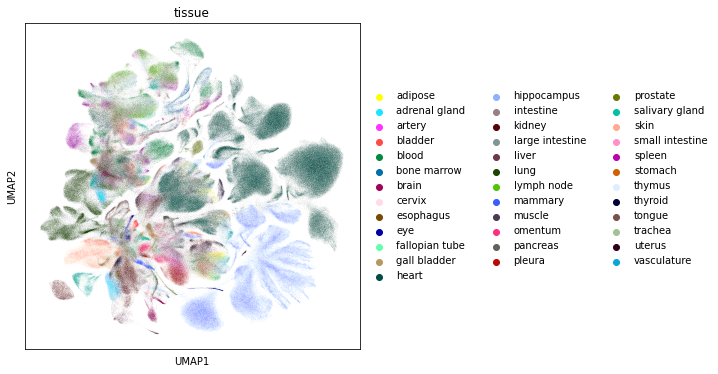

In [27]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = 'tissue')

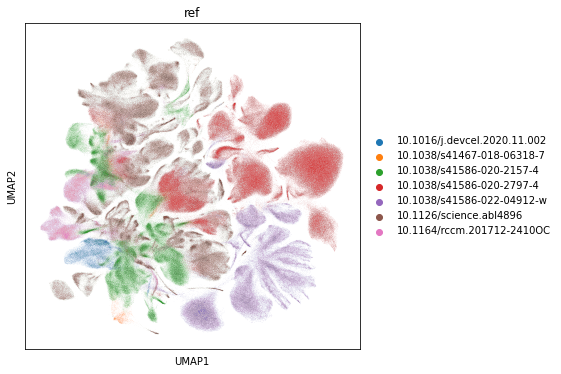

In [29]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = 'ref')

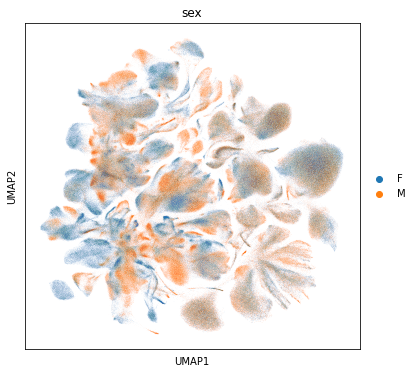

In [30]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = 'sex')

In [36]:
a_dict = {}

for cell in adata.obs.cell_type_2.unique():
    if len(adata[adata.obs.cell_type_2 == cell]) > 20000:
        a_dict[cell] = cell
    else:
        a_dict[cell] = 'other'

In [39]:
adata.obs['temp'] = adata.obs.cell_type_2.map(a_dict)

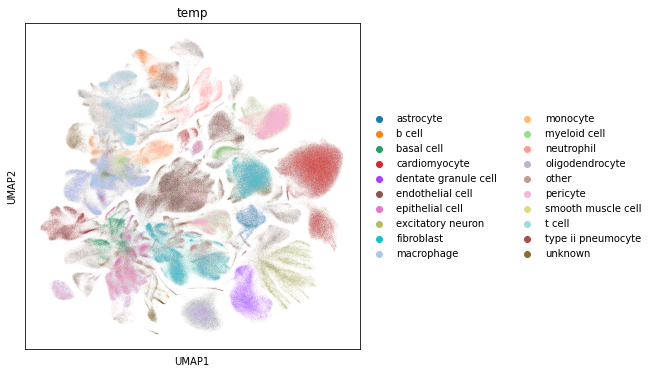

In [40]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = 'temp')

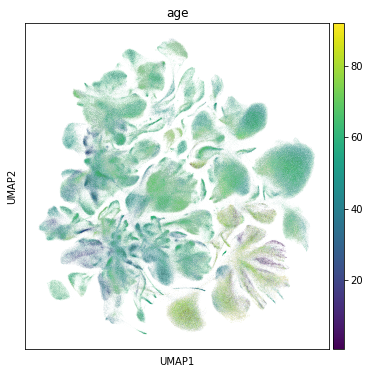

In [42]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = 'age')

In [44]:
!pwd

/home/ubuntu/s3_mount/senescence/paper_1/Notebooks


In [43]:
adata.write_h5ad('/home/ubuntu/volatile/all_cells_scvi.h5ad')

In [56]:
i = np.where(adata.var_names == 'CDKN2A')[0][0]

In [57]:
a = adata.X[:,i].toarray()

In [58]:
a[a > 0] = 1

In [59]:
adata.obs['p16'] = a

In [62]:
adata.obs['p16'] = adata.obs['p16'].astype('category')

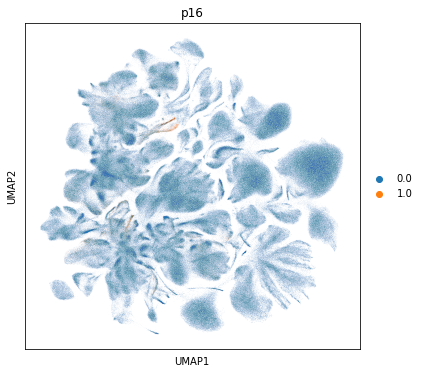

In [63]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = 'p16')

In [20]:
hdata = sc.read_h5ad('/home/ubuntu/s3_mount/Data/tabula_sapiens/TS_harmonized.h5ad')

In [23]:
hdata.obs['cell_type_2'] = hdata.obs.cell_type.map(a_mapper)

In [25]:
temp_d = dict(zip(hdata.obs.cell_type_2, hdata.obs.compartment))

In [28]:
temp = adata.obs.groupby(['cell_type_2']).count().reset_index()

In [30]:
temp['compartment'] = temp.cell_type_2.map(temp_d)

In [33]:
temp[['cell_type_2', 'compartment']].to_csv('../data/annotations/human/cell_classes.csv')

In [36]:
hdata.obs[hdata.obs['cell_type_2'].str.contains('neuron')]

,tissue,tech,donor,cell_type,compartment,gender,age,sex,study,ref,sample,disease,cell_type_2
cell_id,,,,,,,,,,,,,
AATTCCTTCGCGTGAC_TSP5_Eye_NA_10X_1_2,Eye,10X,TSP5,retinal bipolar neuron,stromal,female,40,F,TS,10.1126/science.abl4896,TSP5_Eye,healthy,neuron
ACACAGTCAAGGACAC_TSP5_Eye_NA_10X_1_2,Eye,10X,TSP5,retinal bipolar neuron,stromal,female,40,F,TS,10.1126/science.abl4896,TSP5_Eye,healthy,neuron
ACAGCCGAGTTCCATG_TSP5_Eye_NA_10X_1_2,Eye,10X,TSP5,retinal bipolar neuron,stromal,female,40,F,TS,10.1126/science.abl4896,TSP5_Eye,healthy,neuron
ATCATTCAGGGTCACA_TSP5_Eye_NA_10X_1_2,Eye,10X,TSP5,retinal bipolar neuron,stromal,female,40,F,TS,10.1126/science.abl4896,TSP5_Eye,healthy,neuron
CAATACGCAACAGTGG_TSP5_Eye_NA_10X_1_2,Eye,10X,TSP5,retinal bipolar neuron,stromal,female,40,F,TS,10.1126/science.abl4896,TSP5_Eye,healthy,neuron
CTCCAACCATCGAAGG_TSP5_Eye_NA_10X_1_2,Eye,10X,TSP5,retinal bipolar neuron,stromal,female,40,F,TS,10.1126/science.abl4896,TSP5_Eye,healthy,neuron
CTCTGGTGTCCTACGG_TSP5_Eye_NA_10X_1_2,Eye,10X,TSP5,retinal bipolar neuron,stromal,female,40,F,TS,10.1126/science.abl4896,TSP5_Eye,healthy,neuron
GATCATGCAACGACTT_TSP5_Eye_NA_10X_1_2,Eye,10X,TSP5,retinal bipolar neuron,stromal,female,40,F,TS,10.1126/science.abl4896,TSP5_Eye,healthy,neuron
GTCACTCAGGGATCAC_TSP5_Eye_NA_10X_1_2,Eye,10X,TSP5,retinal bipolar neuron,stromal,female,40,F,TS,10.1126/science.abl4896,TSP5_Eye,healthy,neuron
